# Classfiying CIFAR10 dataset using a deep neural network


## Defining functions


## Importing the libraries


In [1]:
from keras.utils import to_categorical
from keras.datasets import cifar10
from tensorflow import keras
from keras import layers
import tensorflow as tf
import pathlib
import os

import matplotlib.pyplot as plt

MODELS_DIR = pathlib.Path('./models/CIFAR10Classification')
print(tf.config.list_physical_devices('GPU'))


2023-01-06 16:00:25.624404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 16:00:26.025253: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-06 16:00:27.447249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/f

[]


2023-01-06 16:00:29.252891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-06 16:00:29.253026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ERSLegion5Pro): /proc/driver/nvidia/version does not exist


In [2]:
def plot_history(history):
    """Plot training and validation loss and accuracy metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title(
        'Training and validation loss and accuracy')

    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo',
             label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b',
             label='Validation accracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()


def model_evaluation(model, test_images, test_labels, label_dict):
    """Evaluate model performance on test data."""

    (test_loss,
     test_acc,
     test_AUC,
     test_precision,
     test_recall) = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print('Test AUC:', test_AUC)
    print('Test precision:', test_precision)
    print('Test recall:', test_recall)

    predictions = model.predict(test_images)

    confussion_matrix = tf.math.confusion_matrix(
        labels=test_labels.argmax(axis=1),
        predictions=predictions.argmax(axis=1))

    print('Confussion matrix:')
    print(confussion_matrix)

    plt.figure(figsize=(10, 10))
    plt.imshow(confussion_matrix, cmap=plt.cm.Blues)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(labels=list(label_dict.values()), ticks=list(label_dict.keys()))
    plt.yticks(labels=list(label_dict.values()), ticks=list(label_dict.keys()))
    plt.grid(False)
    plt.show()


## Importing the dataset


In [18]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert X_test.shape == (10000, 32, 32, 3)
assert y_test.shape == (10000, 1)


In [4]:
label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}


## Show some images


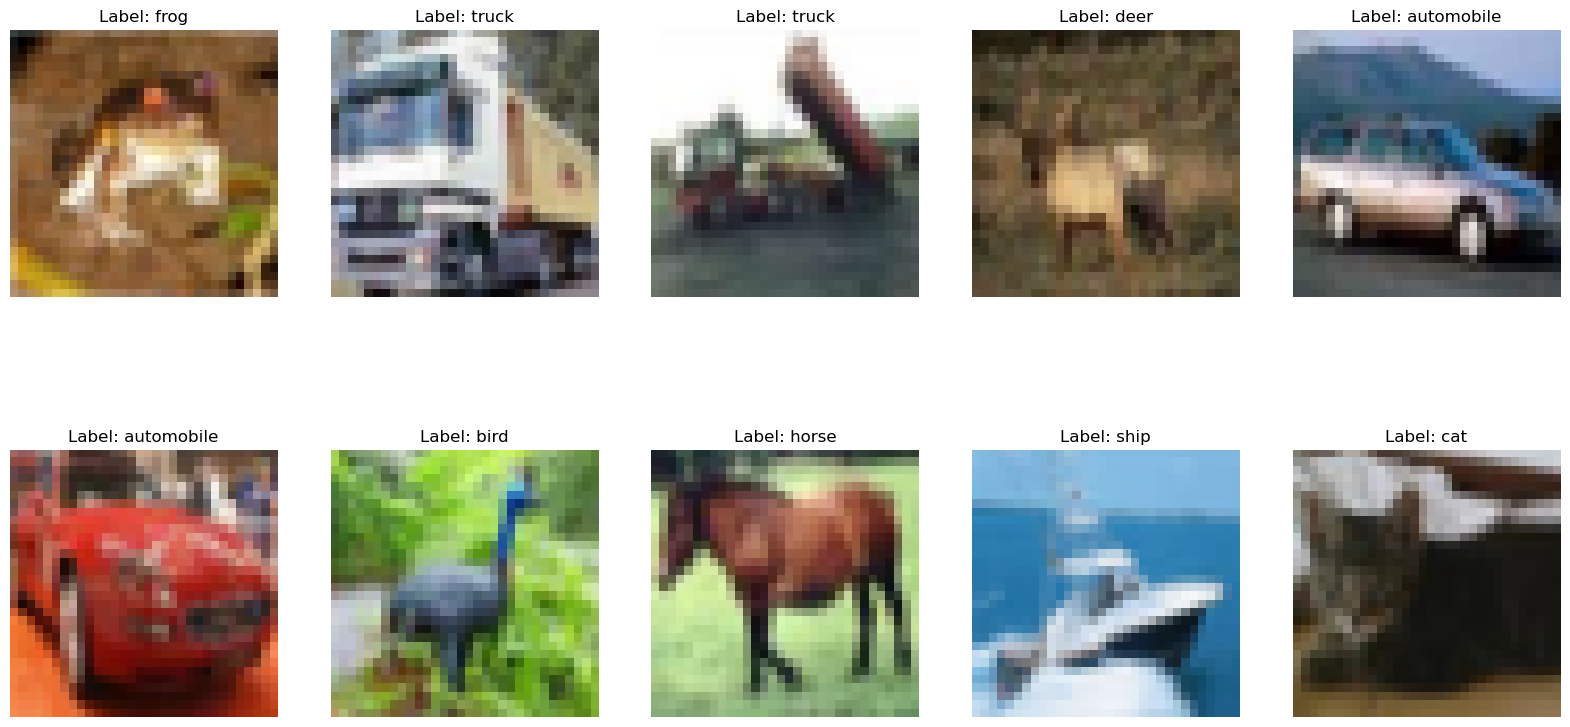

In [5]:
plt.figure(figsize=(20, 10))

for i in range(10):
    subplt = plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title('Label: {}'.format(label_dict[y_train[i][0]]))


## Preprocessing the data


In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [8]:
X_val = X_train[-20000:]
y_val = y_train[-20000:]

X_train = X_train[:-20000]
y_train = y_train[:-20000]

X_train.shape, X_val.shape, X_test.shape


((30000, 32, 32, 3), (20000, 32, 32, 3), (10000, 32, 32, 3))

## Designing a simple multilayer perceptron model


In [9]:
def get_model():
    "Returns a compiled model."
    inputs = keras.Input(shape=(32, 32, 3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='CIFAR10_MLP_Classification')

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model


In [10]:
model = get_model()
model.summary()


Model: "CIFAR10_MLP_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 10) 

2023-01-06 16:01:12.973289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_32.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)


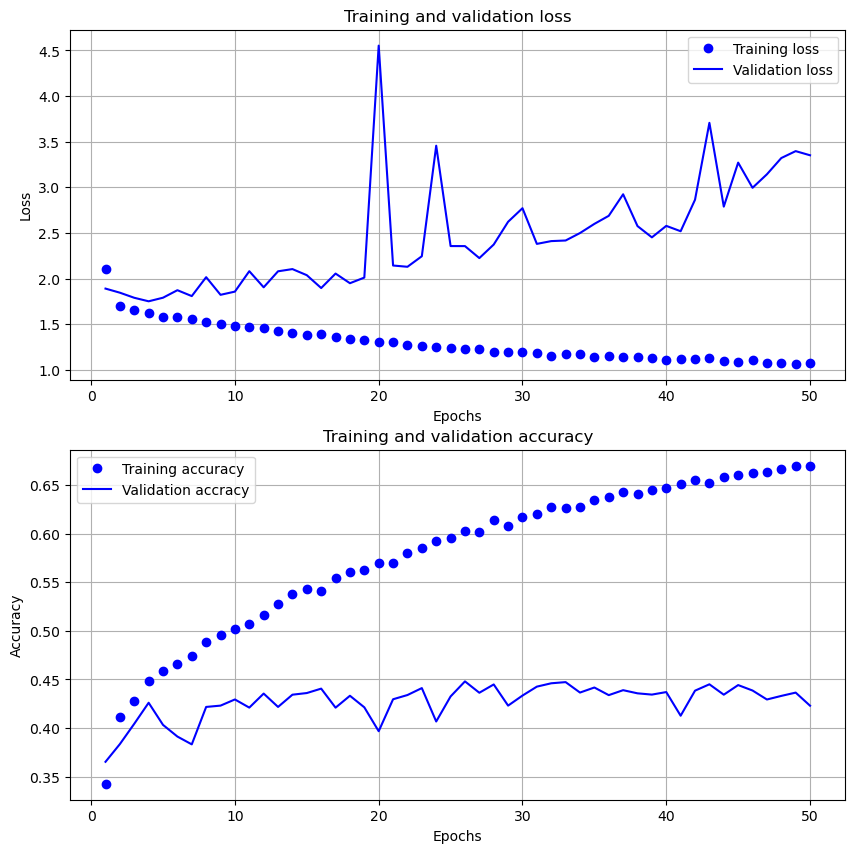

In [ ]:
plot_history(history)


## Evaluating the model


313/313 [==============================] - 2s 6ms/step - loss: 1.7347 - accuracy: 0.4326 - auc: 0.8398 - precision: 0.5982 - recall: 0.2705
Test accuracy: 0.4325999915599823
Test loss: 1.7347209453582764
Test AUC: 0.8398099541664124
Test precision: 0.5981866717338562
Test recall: 0.2705000042915344
313/313 [==============================] - 0s 1ms/step
Confussion matrix:
tf.Tensor(
[[501  49  45  10  29  23  32  30 204  77]
 [ 40 575   8  12  13  19  39  25 102 167]
 [113  27 240  50 112 144 157  69  45  43]
 [ 34  49  71 103  42 321 199  70  44  67]
 [ 61  24 106  30 247 122 189 149  39  33]
 [ 22  31  83  76  82 454 103  74  47  28]
 [ 21  39  54  61  91 109 552  27  24  22]
 [ 82  24  35  25  61 125  49 506  23  70]
 [100  65   7   9  19  40  24  15 636  85]
 [ 44 210  14  14  13  24  31  43  95 512]], shape=(10, 10), dtype=int32)


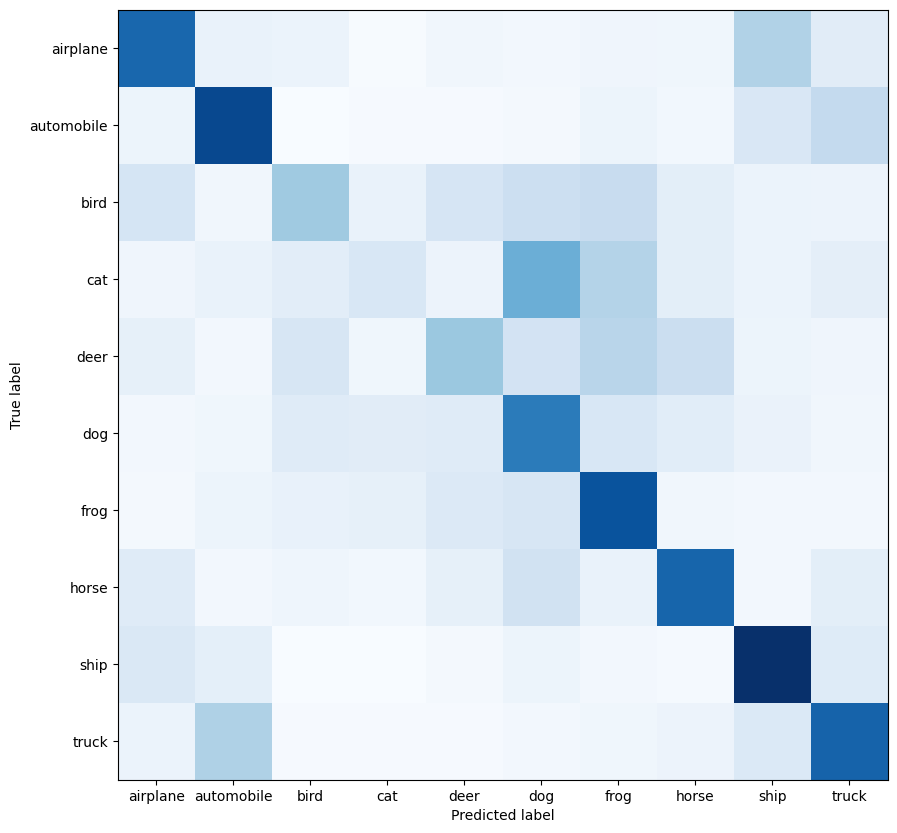

In [ ]:
model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_32.keras'))

model_evaluation(model, X_test, y_test, label_dict)


## Setting different batch sizes

In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_64.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_64.keras'))

model_evaluation(model, X_test, y_test, label_dict)


In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, '2HiddenLayer_MLP_batch_128.keras'),
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=238,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    epochs=50,
                    callbacks=callbacks)

plot_history(history)

model = keras.models.load_model(
    os.path.join(MODELS_DIR, '2HiddenLayer_MLP_batch_128.keras'))

model_evaluation(model, X_test, y_test, label_dict)
